In [165]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from einops import rearrange
from torch.optim import Adam
import torch.nn.functional as F

In [166]:
### Prepare path of image
person = 'anson'
path_list = []
label_list = []
for i in range(10):
    i += 1
    s = r'Data/signature_'+person + r'_numpy/False' + str(i) + r'.npy'
    s2 = r'Data/signature_' + person + r'_numpy/True' + str(i) + r'.npy'
    path_list.append(s)
    path_list.append(s2)
    label_list.append(False)
    label_list.append(True)
label_list = np.array(label_list)

In [167]:
### Load data
data_list = []

for s in path_list:
    data = np.load(s, allow_pickle=True)
    pressure = data[:,2]
    # find out last non-zero pressure data
    idx = 0
    for i, p in enumerate(pressure):
        if p != 0:
            idx = i
    
    # Then pick data fron t=0 to that time point
    data = data[0:idx+1,:]
    # data_list = data_list[: data]
    data_list.append(data)
    
data_set = data_list
# data_set = np.array(data_list)
# data_list

In [168]:
### Draw data on 2D canvas
data_set_image = []
for i in range(len(data_set)):
    data = data_set[i]
    canvas = np.zeros((240,320))
    x_coords = data[:,0]
    y_coords = data[:,1]
    pressure = data[:,2]

    for i, p in enumerate(pressure):
        x = x_coords[i]
        y = y_coords[i]
        if p != 0:
            canvas[240-x,y] = p
    data_set_image.append(canvas)

data_set_image = np.array(data_set_image)

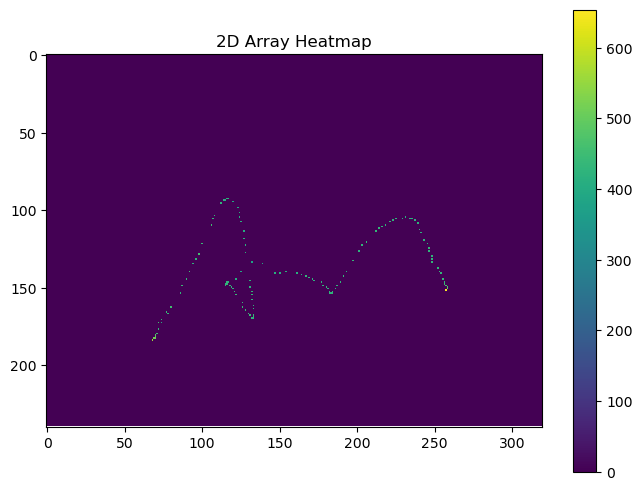

In [202]:
# Generating a 2D NumPy array with random values
# data = np.random.rand(10, 10)
data = data_set_image[2]
# Plotting the 2D array as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('2D Array Heatmap')
plt.show()

In [203]:
# Convert data to PyTorch tensors and change shape to [N, C, W, H]
data = torch.tensor(data_set_image).float()  # PyTorch expects channel-first format
rearrange(data, 'n b h -> n 1 b h')
labels = torch.tensor(label_list).long()

# # Split data into training and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(data_train, labels_train)
val_dataset = TensorDataset(data_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [205]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.MaxPool2d(kernel_size=2,stride = 2) #nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Assuming input channels = 3
        self.layer2 = nn.ReLU(nn.Conv2d(1,3, kernel_size=3, stride = 1, padding = None))
        self.layer3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = nn.ReLU(nn.Conv2d(3,6, kernel_size=3, stride = 1, padding = None))  # Adjust input size based on your data
        self.layer5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer6 = nn.Flatten()
        self.layer7 = nn.Linear(1200, 2)  # Assuming 10 output classes
        # self.layer8 = nn.Sigmoid()
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        # x = self.layer8(x)
        return x

In [206]:
# Model, Loss, and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [209]:
# Training Loop
num_epochs = 10  # Example epoch count
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [57]:
theta = 90 - math.degrees(math.atan(test[2]/test[1]))
theta = math.radians(theta)

cos_t = math.cos(theta)
sin_t = math.sin(theta)
rotation_mat = np.array([[cos_t, -sin_t],[sin_t, cos_t]])
rotation_mat

array([[ 0.43400616, -0.9009099 ],
       [ 0.9009099 ,  0.43400616]])

In [ ]:
# dummy_input = torch.randn(1, 1, 240, 320)
for i in range(19):

    print("Ground truth: ", label_list[i])
    input = torch.tensor(data_set_image[i], dtype=torch.float32)
    # input = torch.randn(240,320)
    # plt.figure(figsize=(8, 6))
    # plt.imshow(input, cmap='viridis', interpolation='nearest')
    # plt.colorbar()
    # plt.title('2D Array Heatmap')
    # plt.show()
    input = input.unsqueeze(0)
    input = input.unsqueeze(0)

    with torch.no_grad():
        output = model(input)

    probability = F.softmax(output, dim =1)
    probability
    print(probability)